In [230]:
import json
import pandas as pd
from PIL import Image as pi
from IPython.display import Image, display
import plotly.express as px
import plotly.graph_objs as go


In [223]:
out = 'out/20220718004929/'

In [189]:
d = []
for suffix in ['par', 'seq']:
    with open(out+f'bench_{suffix}.json', 'r') as f:
        d += json.load(f)['results']
df = pd.DataFrame(d)
assert df['exit_codes'].apply(lambda x: sum(x)).sum() == 0
df['obs'] = df['times'].apply(lambda x: len(x))
df['ci'] = 1.960 * df['stddev'] / (df['obs']**0.5)
df = df.join(pd.DataFrame(df['parameters'].values.tolist()))
df['num_threads'] = df['num_threads'].fillna(1)
df = df.astype({'strat':'string','region':'string','bench':int,
                'num_threads':int,'size':int})
assert df.isna().sum().sum() == 0
cols = ['strat','bench','region','num_threads','size','obs',
        'min','mean','max','stddev','ci']
df = df[cols].set_index(['strat','bench','region','num_threads','size'])
df = df.sort_index()
df['speedup'] = 1
for i, r in df.iterrows():
    df.at[i,'speedup'] = df.at[('seq',1,i[2],1,i[4]),'mean']/r['mean']
df = df.reset_index()
def fn(x):
    match x['strat']:
        case 'seq':
            match x['bench']:
                case 0:
                    return '1. Sequential (I/O & Mem.)'
                case 1:
                    return '2. Sequential'
        case 'pth':
            return '3. Pthreads'
        case 'omp':
            return '4. OpenMP'
df.insert(0, 'algorithm', df.apply(fn, axis=1))
df.to_csv(out+'data.csv', index=False)
df.sample(10)

,algorithm,strat,bench,region,num_threads,size,obs,min,mean,max,stddev,ci,speedup
84,4. OpenMP,omp,1,full,4,256,10,0.009567,0.009911,0.010814,0.000362,0.000224,1.359390
476,3. Pthreads,pth,1,spiral,32,1024,10,0.253125,0.256575,0.261528,0.002521,0.001563,5.024144
230,4. OpenMP,omp,1,spiral,32,16,10,0.003514,0.003718,0.004494,0.000288,0.000178,0.805597
15,4. OpenMP,omp,1,elephant,2,512,10,0.154020,0.154573,0.155445,0.000517,0.000321,1.822362
112,4. OpenMP,omp,1,full,32,64,10,0.004195,0.004310,0.004455,0.000084,0.000052,0.746991
491,1. Sequential (I/O & Mem.),seq,0,full,1,32,10,0.002741,0.003193,0.003486,0.000211,0.000131,0.884111
212,4. OpenMP,omp,1,spiral,8,64,10,0.004186,0.005407,0.007420,0.001003,0.000622,1.516590
452,3. Pthreads,pth,1,spiral,8,64,10,0.003401,0.003708,0.004057,0.000188,0.000116,2.211883
387,3. Pthreads,pth,1,seahorse,4,2048,10,1.422668,1.504164,1.581471,0.052066,0.032271,3.040031
448,3. Pthreads,pth,1,spiral,4,4096,10,6.659026,6.721059,6.825663,0.047531,0.029460,3.014250


In [ ]:
def line(error_y_mode=None, **kwargs):
    """Extension of `plotly.express.line` to use error bands.
    Source: https://stackoverflow.com/a/69594497"""
    ERROR_MODES = {'bar','band','bars','bands',None}
    if error_y_mode not in ERROR_MODES:
        raise ValueError(f"'error_y_mode' must be one of {ERROR_MODES}, received {repr(error_y_mode)}.")
    if error_y_mode in {'bar','bars',None}:
        fig = px.line(**kwargs)
    elif error_y_mode in {'band','bands'}:
        if 'error_y' not in kwargs:
            raise ValueError(f"If you provide argument 'error_y_mode' you must also provide 'error_y'.")
        figure_with_error_bars = px.line(**kwargs)
        fig = px.line(**{arg: val for arg,val in kwargs.items() if arg != 'error_y'})
        for data in figure_with_error_bars.data:
            x = list(data['x'])
            y_upper = list(data['y'] + data['error_y']['array'])
            y_lower = list(data['y'] - data['error_y']['array'] if data['error_y']['arrayminus'] is None else data['y'] - data['error_y']['arrayminus'])
            color = f"rgba({tuple(int(data['line']['color'].lstrip('#')[i:i+2], 16) for i in (0, 2, 4))},.3)".replace('((','(').replace('),',',').replace(' ','')
            fig.add_trace(
                go.Scatter(
                    x = x+x[::-1],
                    y = y_upper+y_lower[::-1],
                    fill = 'toself',
                    fillcolor = color,
                    line = dict(
                        color = 'rgba(255,255,255,0)'
                    ),
                    hoverinfo = "skip",
                    showlegend = False,
                    legendgroup = data['legendgroup'],
                    xaxis = data['xaxis'],
                    yaxis = data['yaxis'],
                )
            )
        # Reorder data as said here: https://stackoverflow.com/a/66854398/8849755
        reordered_data = []
        for i in range(int(len(fig.data)/2)):
            reordered_data.append(fig.data[i+int(len(fig.data)/2)])
            reordered_data.append(fig.data[i])
        fig.data = tuple(reordered_data)
    return fig

In [208]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

n_colors = 6
colors = px.colors.sample_colorscale(
    'plasma_r', 
    [n/(n_colors -1) for n in range(n_colors)])
colors = ['#'+rgb_to_hex(eval(c.lstrip('rgb'))) for c in colors]
colors

['#f0f921', '#fba836', '#e06561', '#b02a90', '#6901a6', '#0d0887']

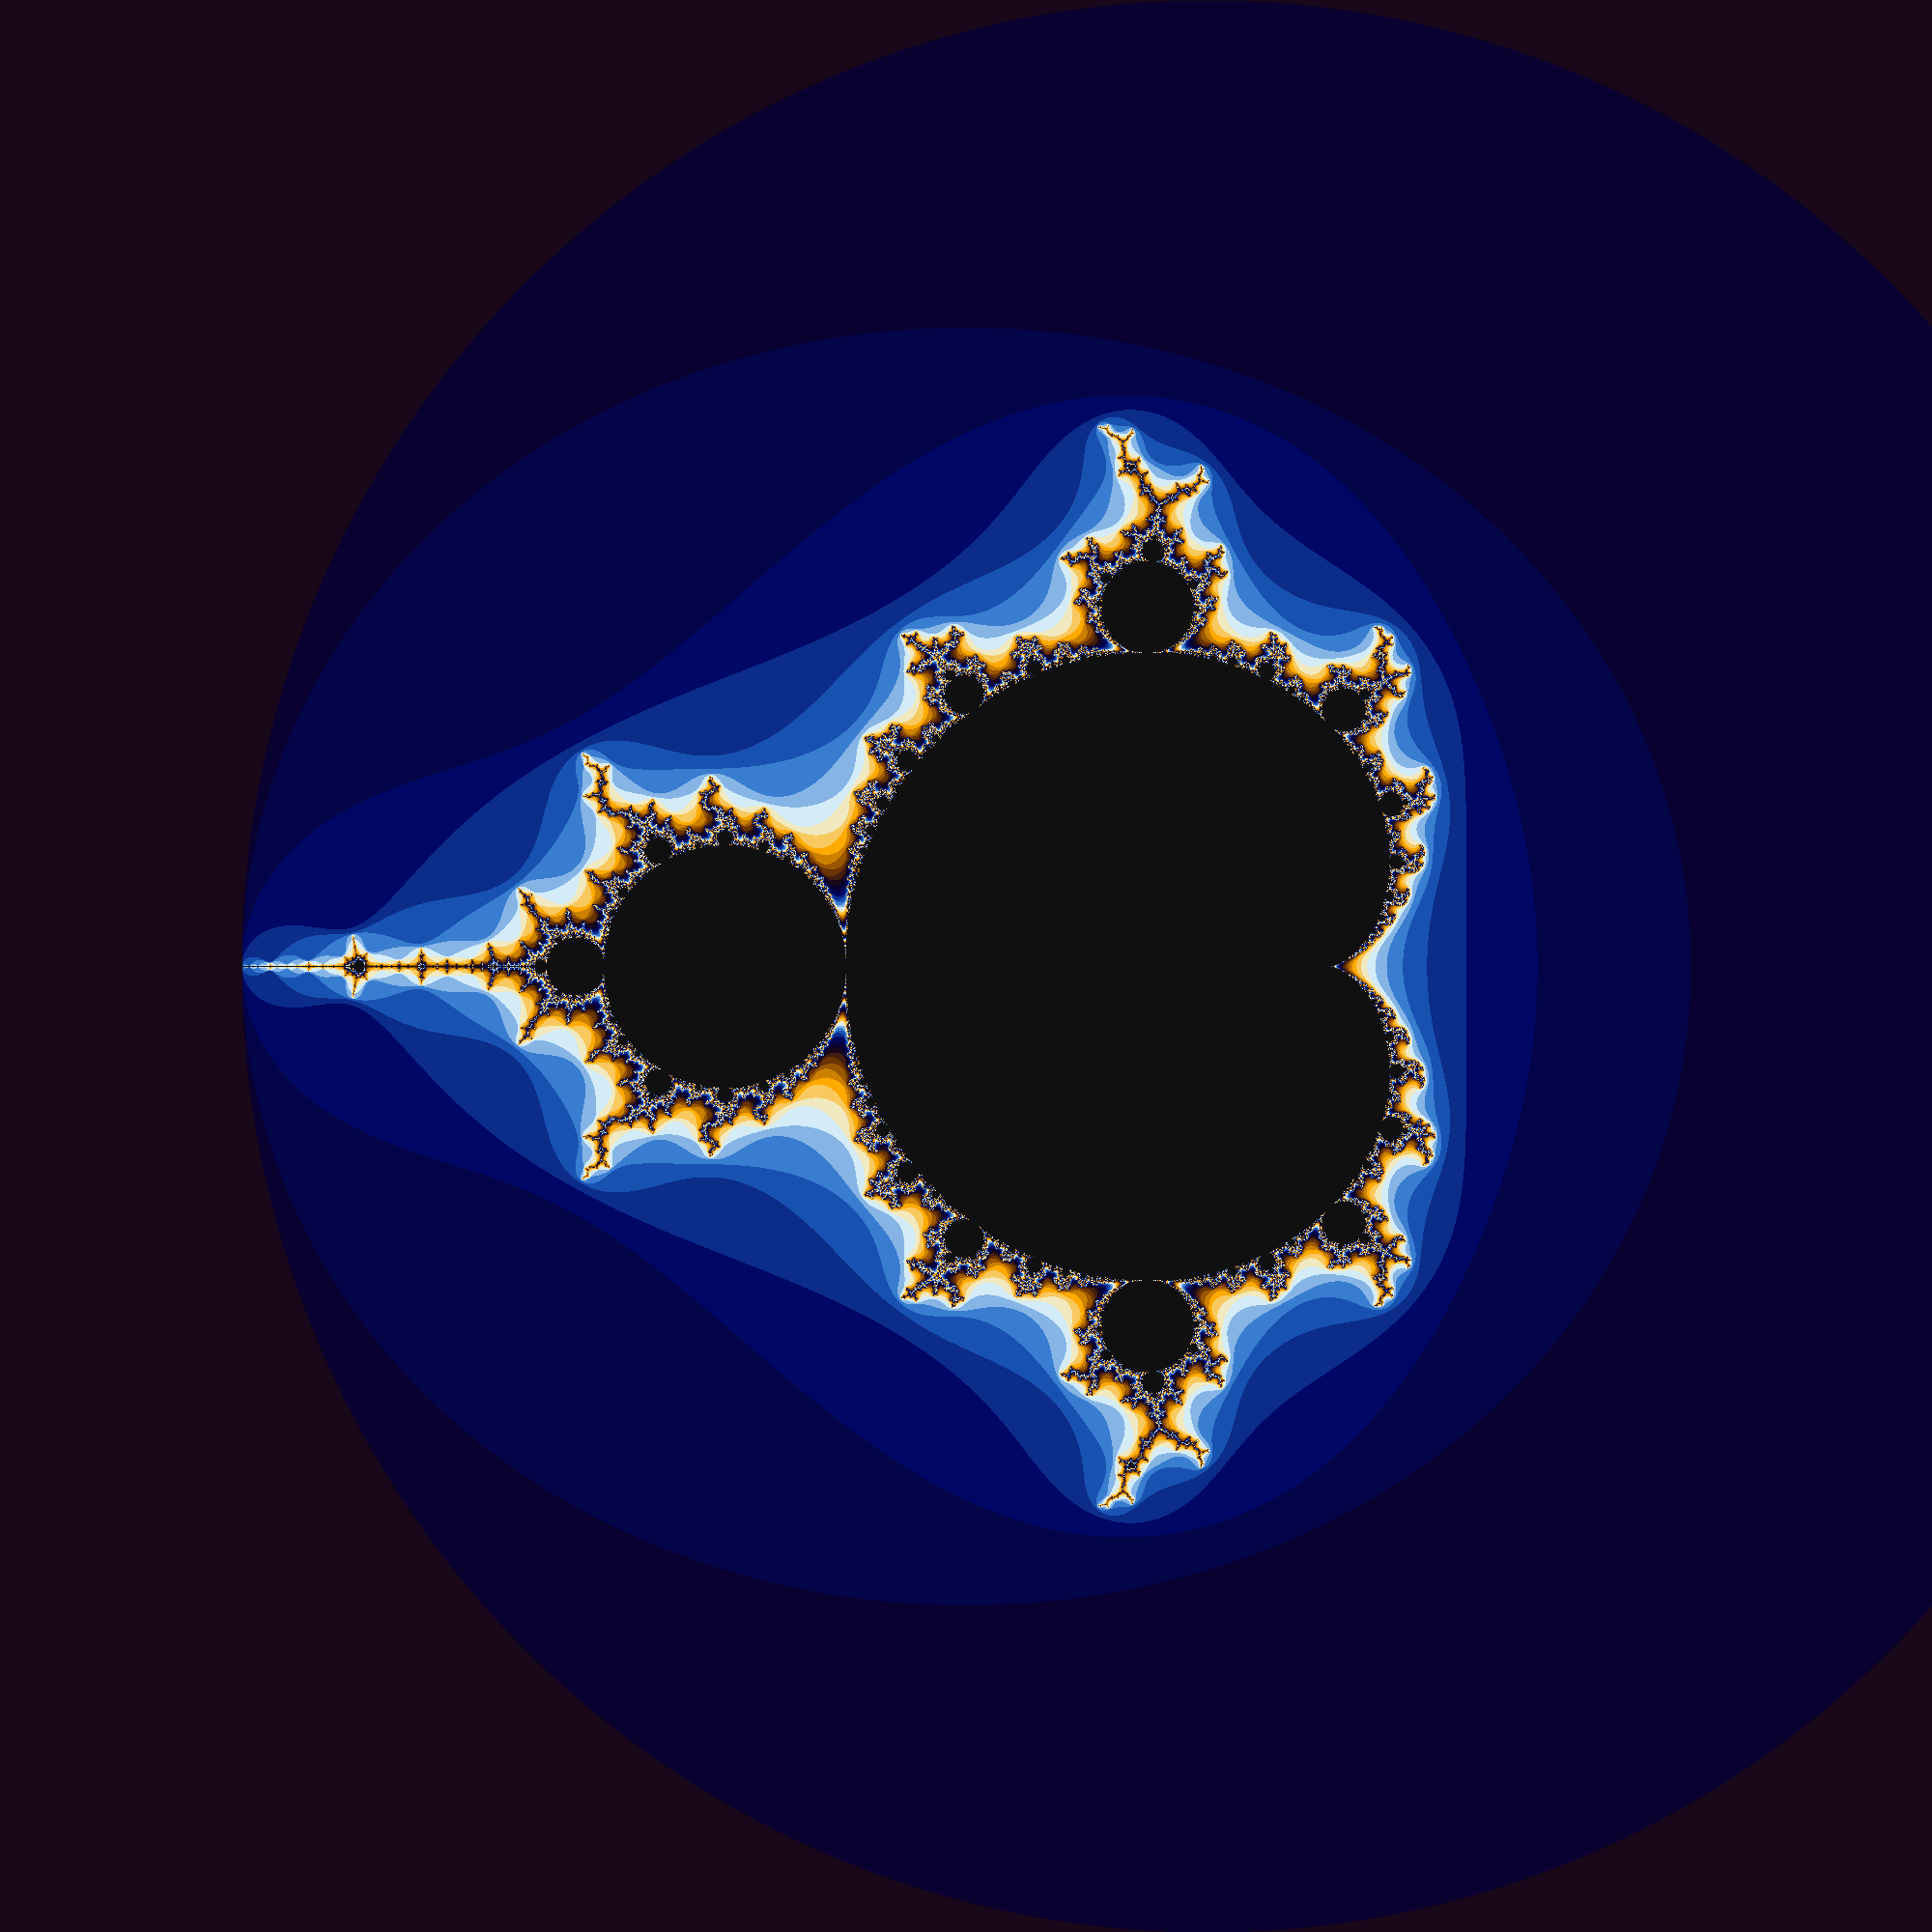

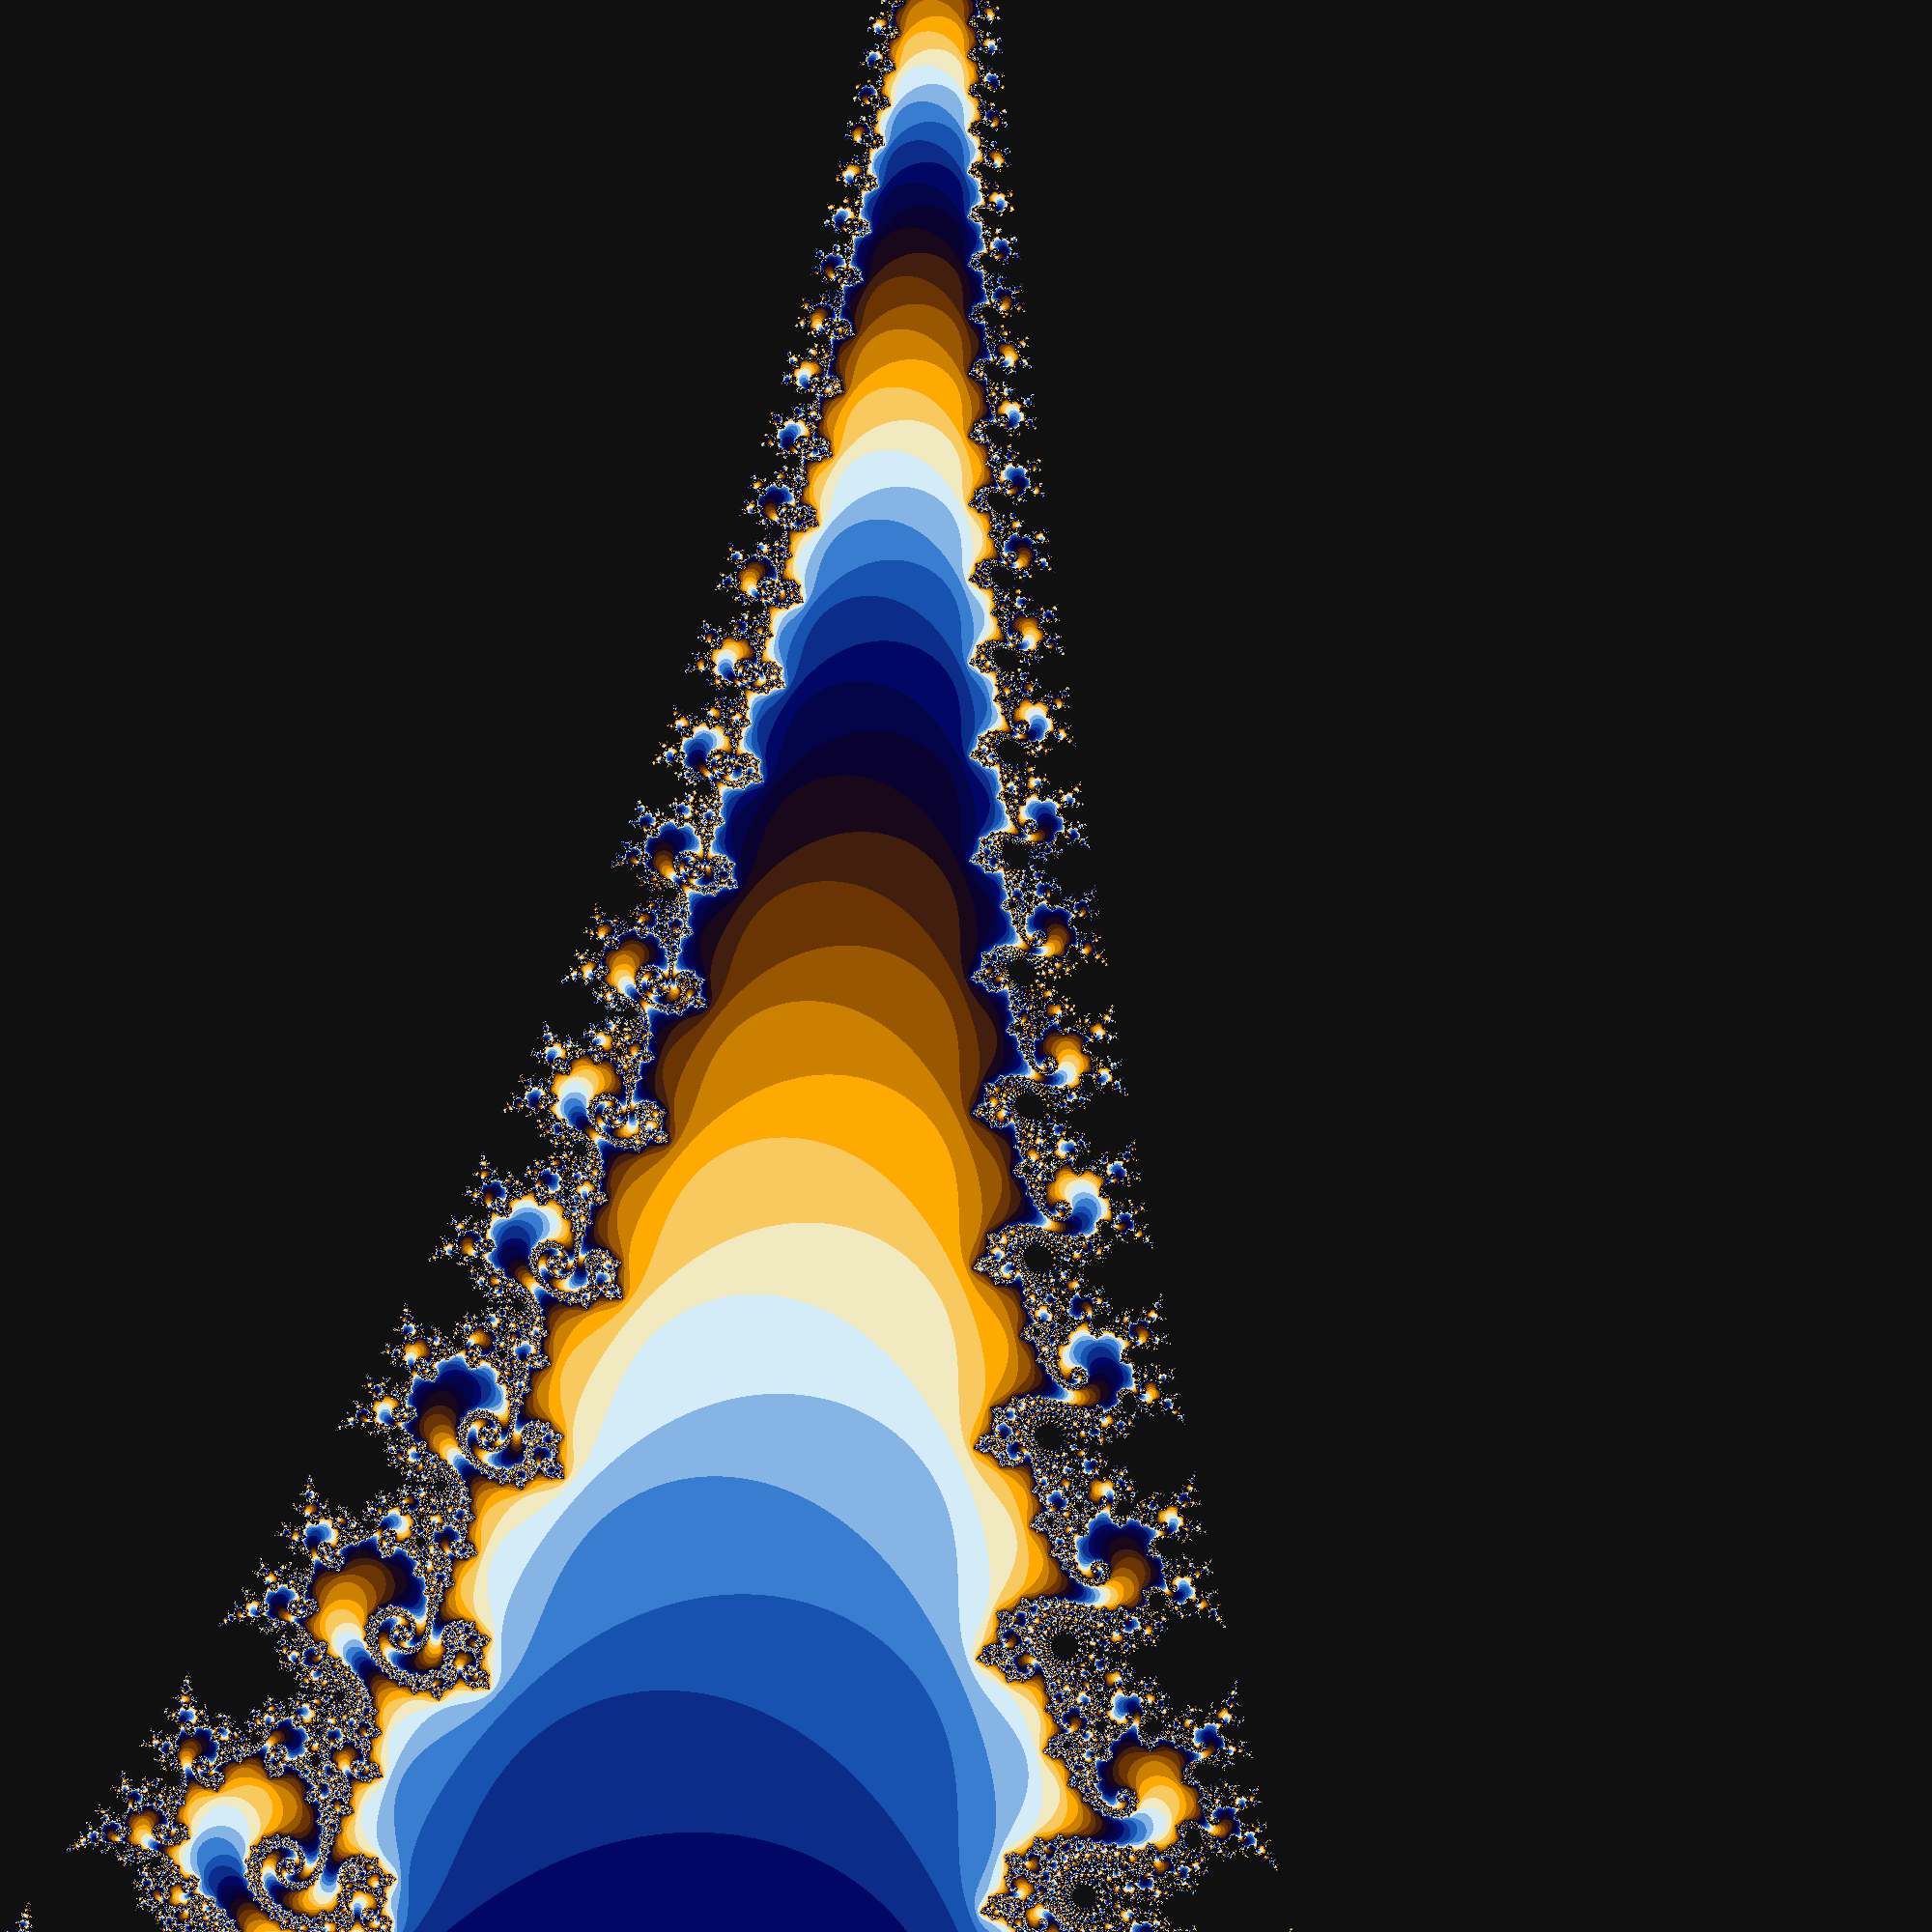

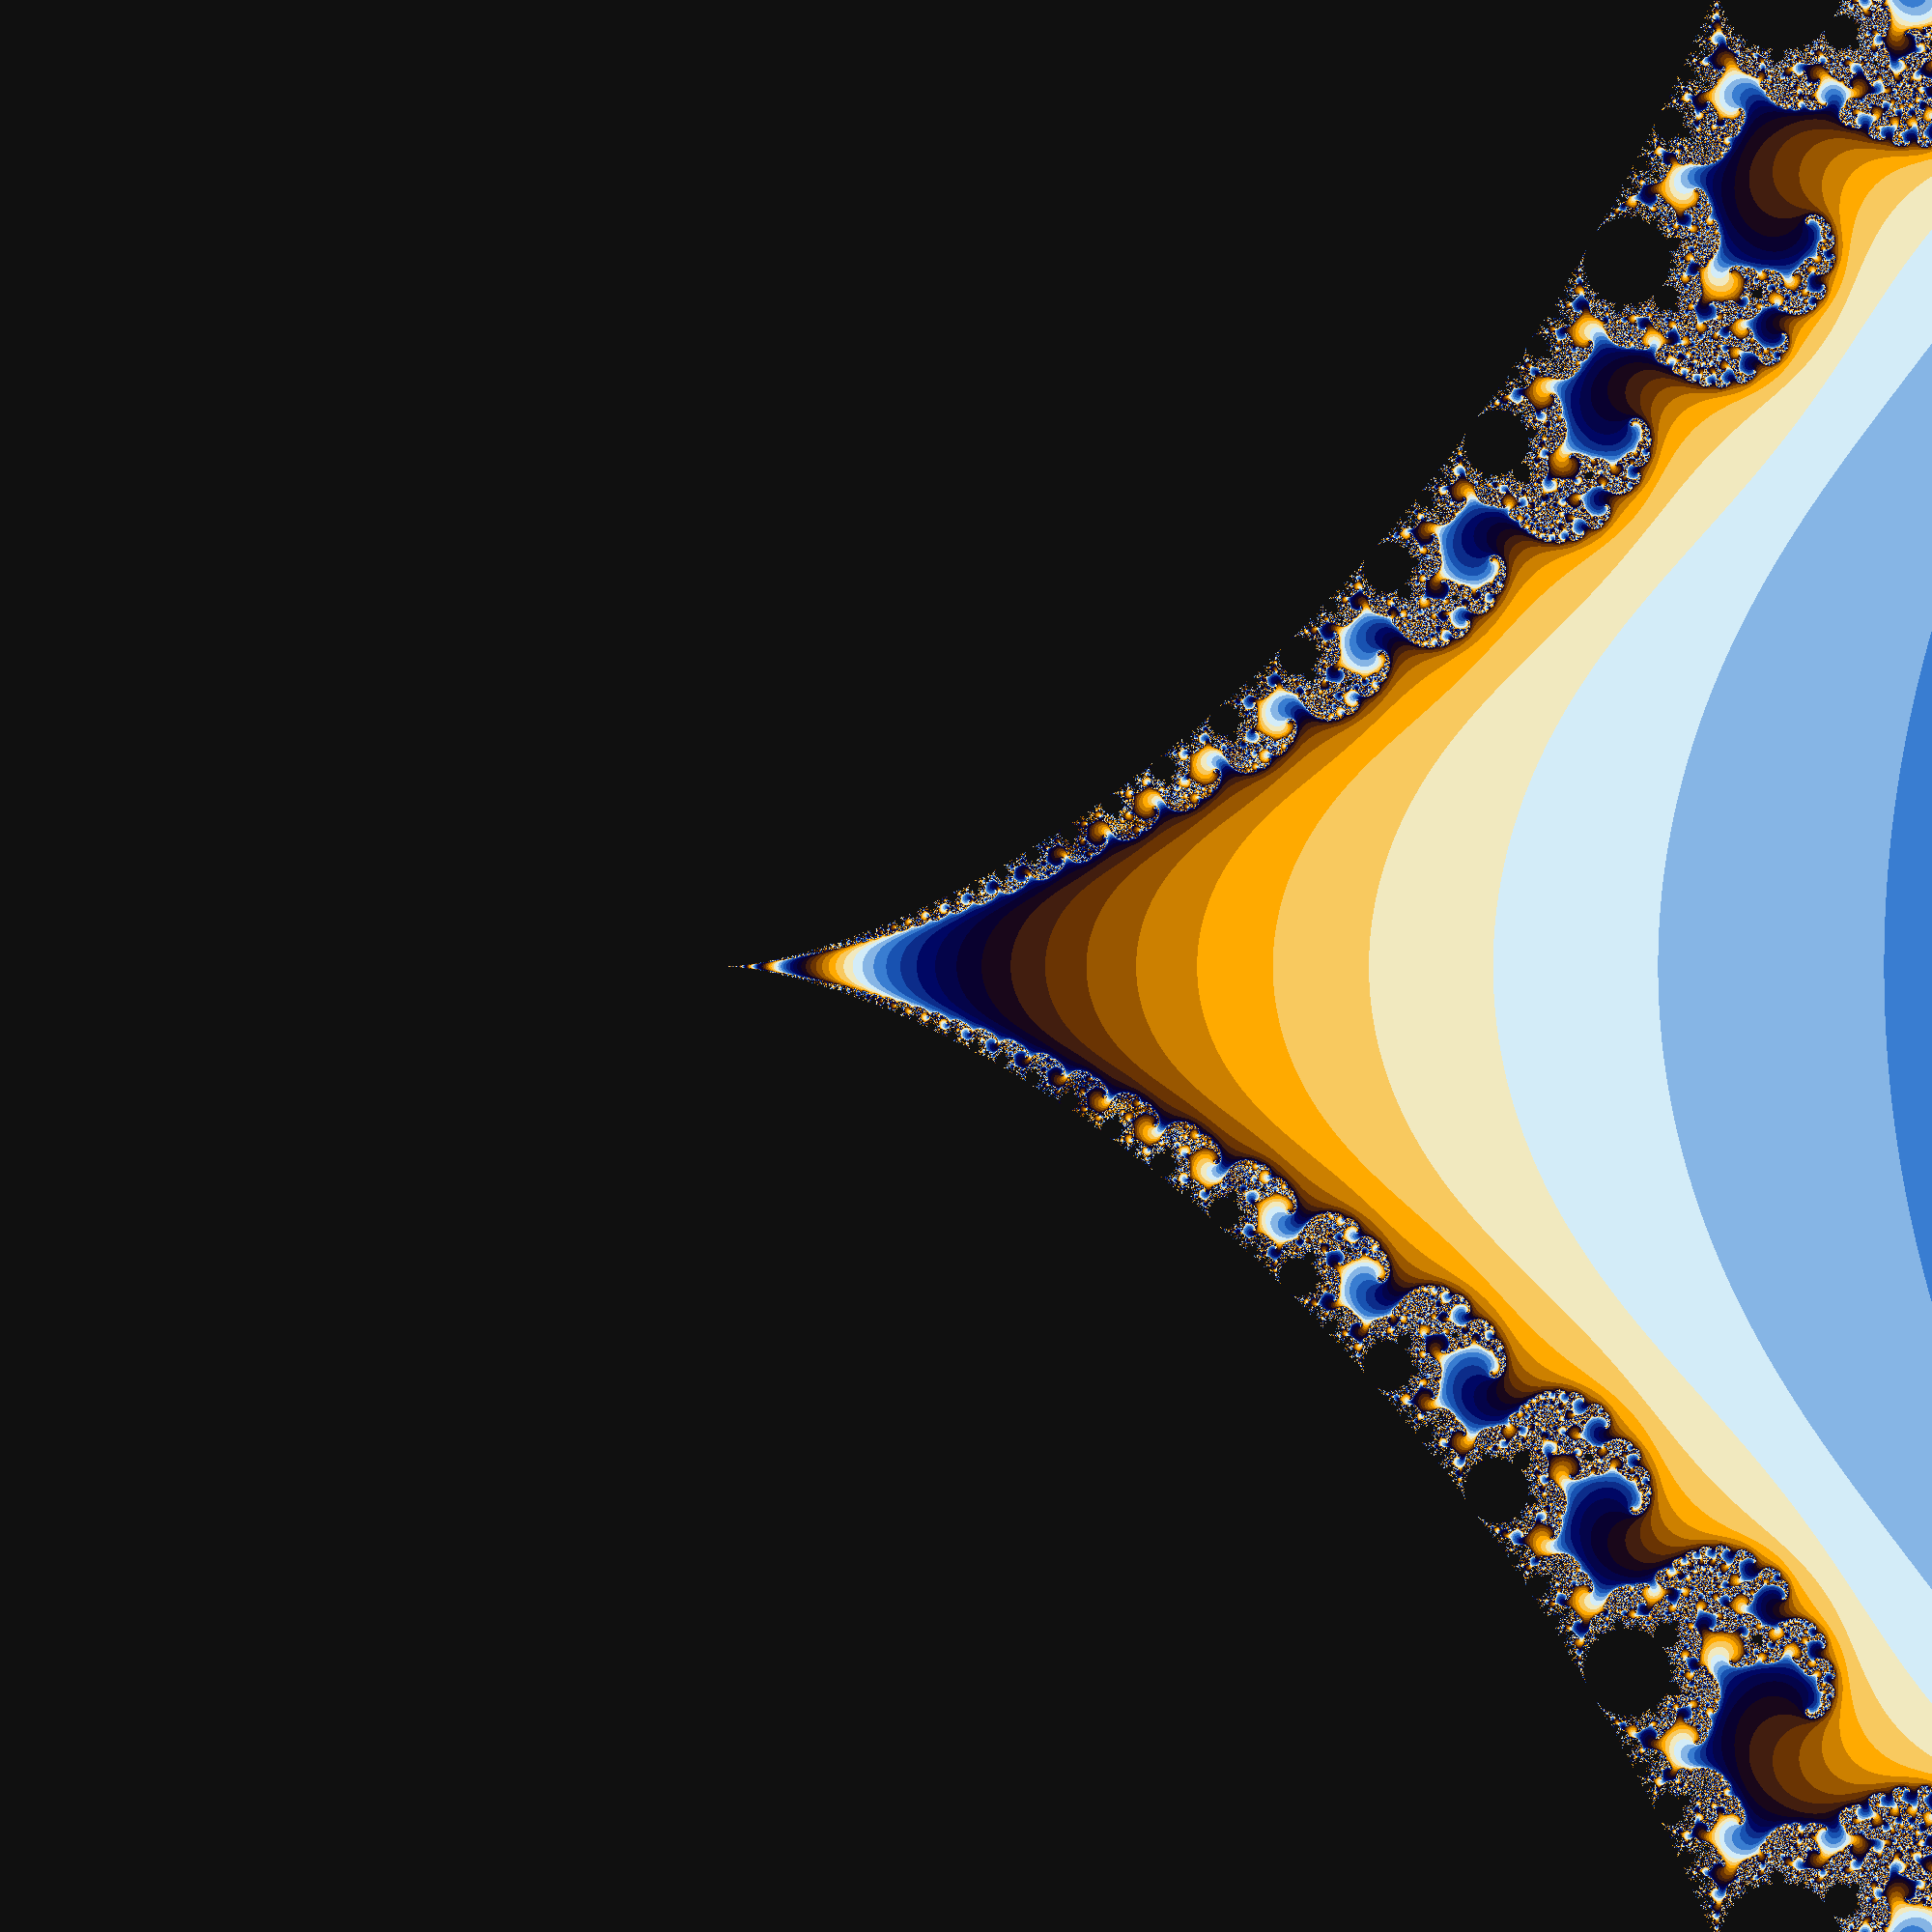

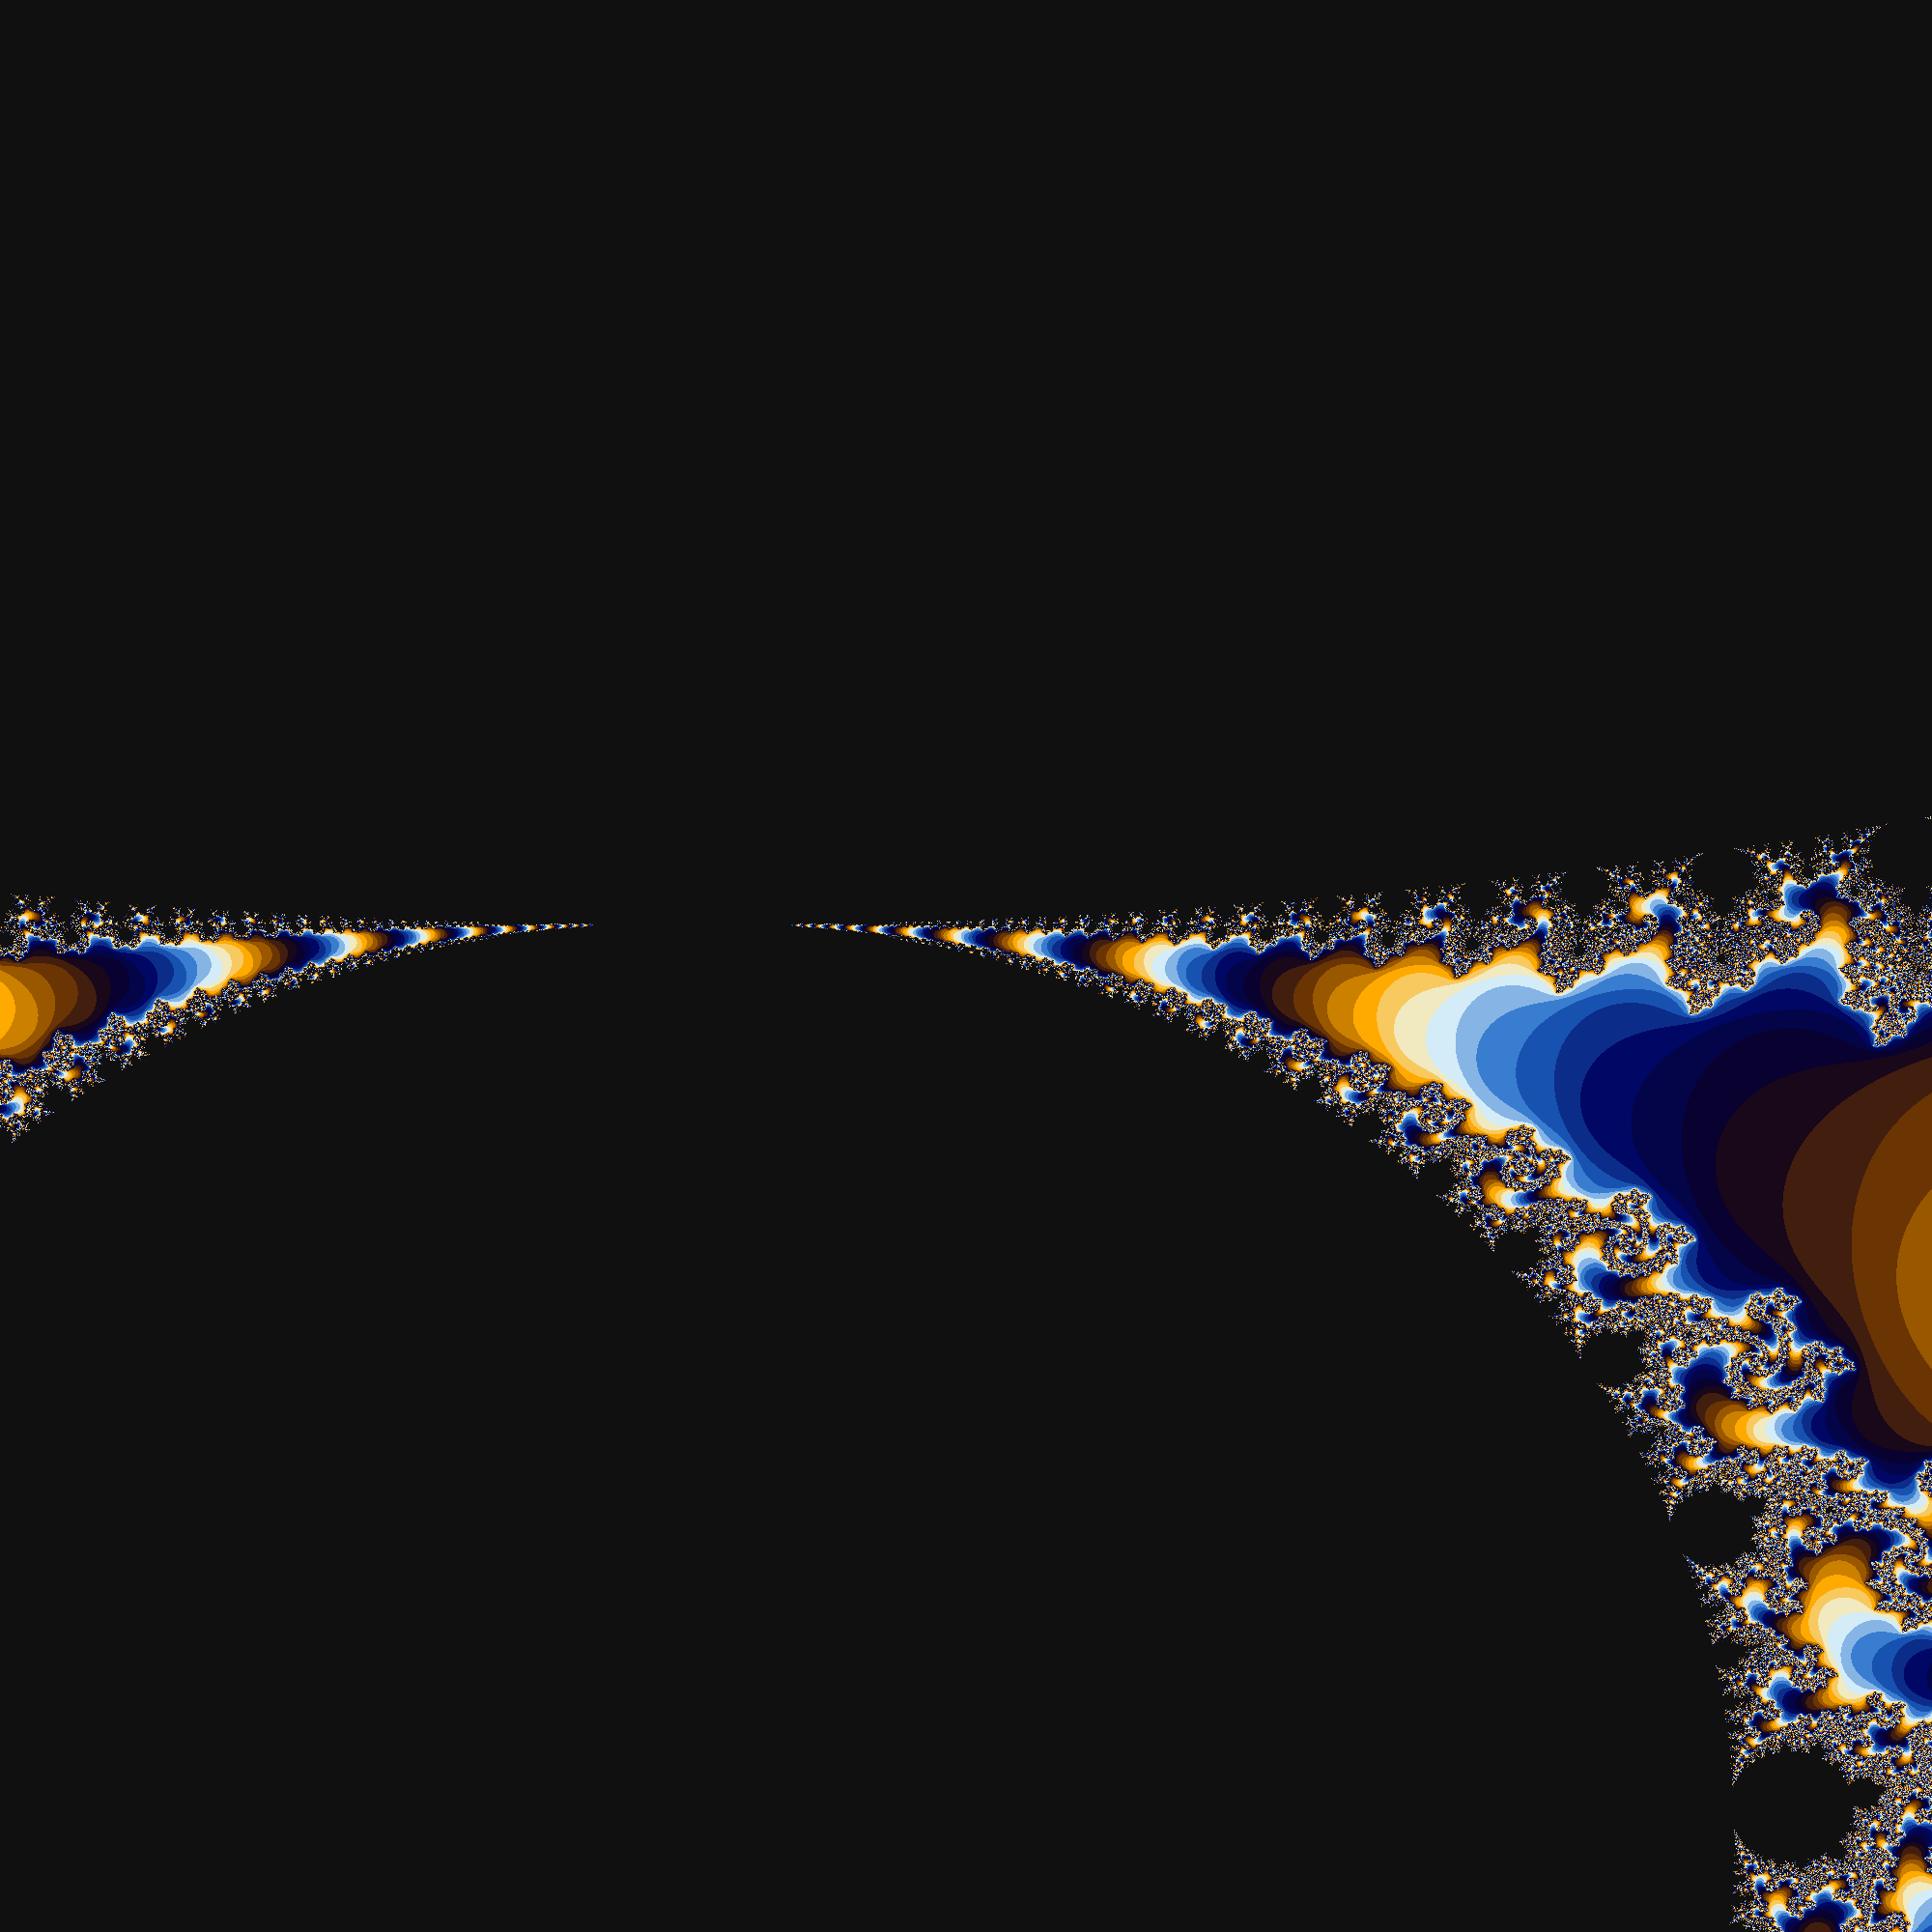

In [231]:
for region in ['full', 'seahorse', 'elephant', 'spiral']:

    # Plot fractal
    with pi.open(out+f'seq_{region}.ppm') as im:
        im.save(out+f'plot_{region}.png')
    display(Image(filename=out+f'plot_{region}.png'))

    # Plot execution time for sequential algorithm
    fig = line(
        data_frame=df[(df['region'] == region) & (df['strat'] == 'seq')],
        title=f'Region = {region}, Algorithm = Sequential, Threads = 1',
        x='size',
        y='mean',
        log_y=True,
        error_y = 'ci',
        error_y_mode = 'band',
        color='bench',
        color_discrete_sequence=colors)
    fig.update_xaxes(type='category')
    fig.update_layout(margin=dict(l=0, r=120, t=50, b=0))
    fig.write_image(out+f'plot_{region}_seq.png', scale=2)
    fig.show()

    # Plot execution time for pth and omp
    for algorithm in ['3. Pthreads','4. OpenMP']:
        fig = line(
            data_frame=df[(df['region'] == region) & (df['algorithm'] == algorithm)],
            title=f'Region = {region}, Algorithm = {algorithm.split(" ")[1]}, Bench = 1',
            x='size',
            y='mean',
            log_y=True,
            error_y = 'ci',
            error_y_mode = 'band',
            color='num_threads',
            color_discrete_sequence=colors)
        fig.update_xaxes(type='category')
        fig.update_layout(margin=dict(l=0, r=120, t=50, b=0))
        # fig.write_image(out+f'{array_size}.png', scale=2)
        fig.write_image(out+f'plot_{region}_{algorithm.split(" ")[1].lower()[:3]}.png', scale=2)
        fig.show()

    # Plot and compare speedups
    max_threads = df['num_threads'].max()
    df_filtered = df[(df['region'] == region) \
                    & ((df['num_threads'] == max_threads) \
                        | (df['strat'] == 'seq'))]
    df_filtered = df_filtered.sort_values(['algorithm','size'])
    fig = px.bar(
        df_filtered, 
        x='size', y=f'speedup',
        color='algorithm', barmode='group', text_auto=True,
        title=f'Region = {region}, Max threads')
    fig.update_yaxes(title='speedup')
    fig.update_xaxes(type='category')
    fig.update_traces(textposition='outside')
    fig.update_layout(yaxis_tickformat='.2f',
        margin=dict(l=0, r=0, t=40, b=0),
        legend_x=0,
        legend_bgcolor='rgba(0,0,0,0)')
    fig.write_image(out+f'plot_{region}_speedups.png', scale=2)
    fig.show()

In [235]:
print(df[(df.strat == 'seq') & (df.bench == 0)]['speedup'].min())
print(df[(df.strat == 'seq') & (df.bench == 0)]['speedup'].max())

0.4888882271055491
0.993277703836706
